In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

pd.set_option("display.max_columns", None)

%run pandas-missing-extension.ipynb

# EDA and FEATURE ENGINERRING

In [2]:
data_path = f"./data/dataset_DepPlazo.csv"

data = pd.read_csv(data_path)
data.head(2)

,ID_SEC,FLGSEXO,TIPESTCIVIL,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,EDAD,DEPARTAMENTO,INGRESO_ESTIMADO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,FLG_VTA
0,169124,M,SOL,NDI,DEP,33,MOQUEGUA,8087.06,D,DIGITAL ALTO,SEG_4,0
1,59736,M,CAS,MAE,DEP,44,LIMA,19000.00,B,DIGITAL ALTO,SEG_5,0


In [3]:
data.nunique()

ID_SEC                 169059
FLGSEXO                     2
TIPESTCIVIL                 6
TIPNIVELEDUCACIONAL        13
TIPSITUACIONLABORAL         7
EDAD                       86
DEPARTAMENTO               25
INGRESO_ESTIMADO       130253
NIVEL_SOCIECON              4
SEGMENTO_DIGITAL            3
SEGMENTO_BANCO             12
FLG_VTA                     2
dtype: int64

In [4]:
del data['ID_SEC']
#Se elimina el ID_SEC porque al ser valores unicos y de identificación no aportará nada al modelo

In [5]:
data.dtypes
#Los tipos de datos lucen correctos de acuerdo a la descripción en el diccionario brindado

FLGSEXO                 object
TIPESTCIVIL             object
TIPNIVELEDUCACIONAL     object
TIPSITUACIONLABORAL     object
EDAD                     int64
DEPARTAMENTO            object
INGRESO_ESTIMADO       float64
NIVEL_SOCIECON          object
SEGMENTO_DIGITAL        object
SEGMENTO_BANCO          object
FLG_VTA                  int64
dtype: object

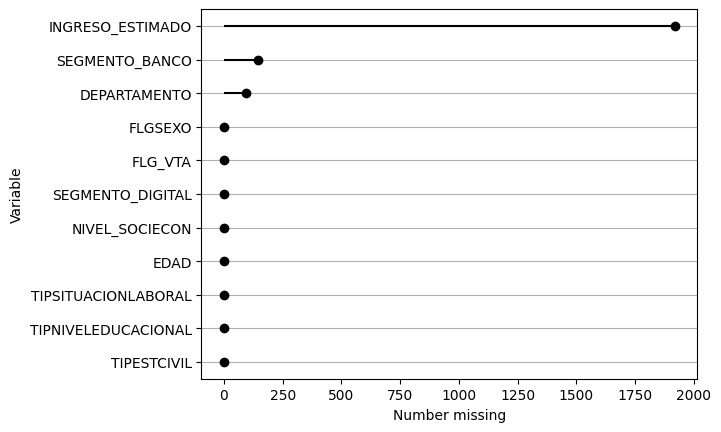

In [6]:
data.missing.missing_variable_plot()
#se visualiza la cantidad de datos nulos por cada variable

c:\Users\EDSON\Desktop\DATAWRANGLING\venv\lib\site-packages\missingno\missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
c:\Users\EDSON\Desktop\DATAWRANGLING\venv\lib\site-packages\missingno\missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot:>

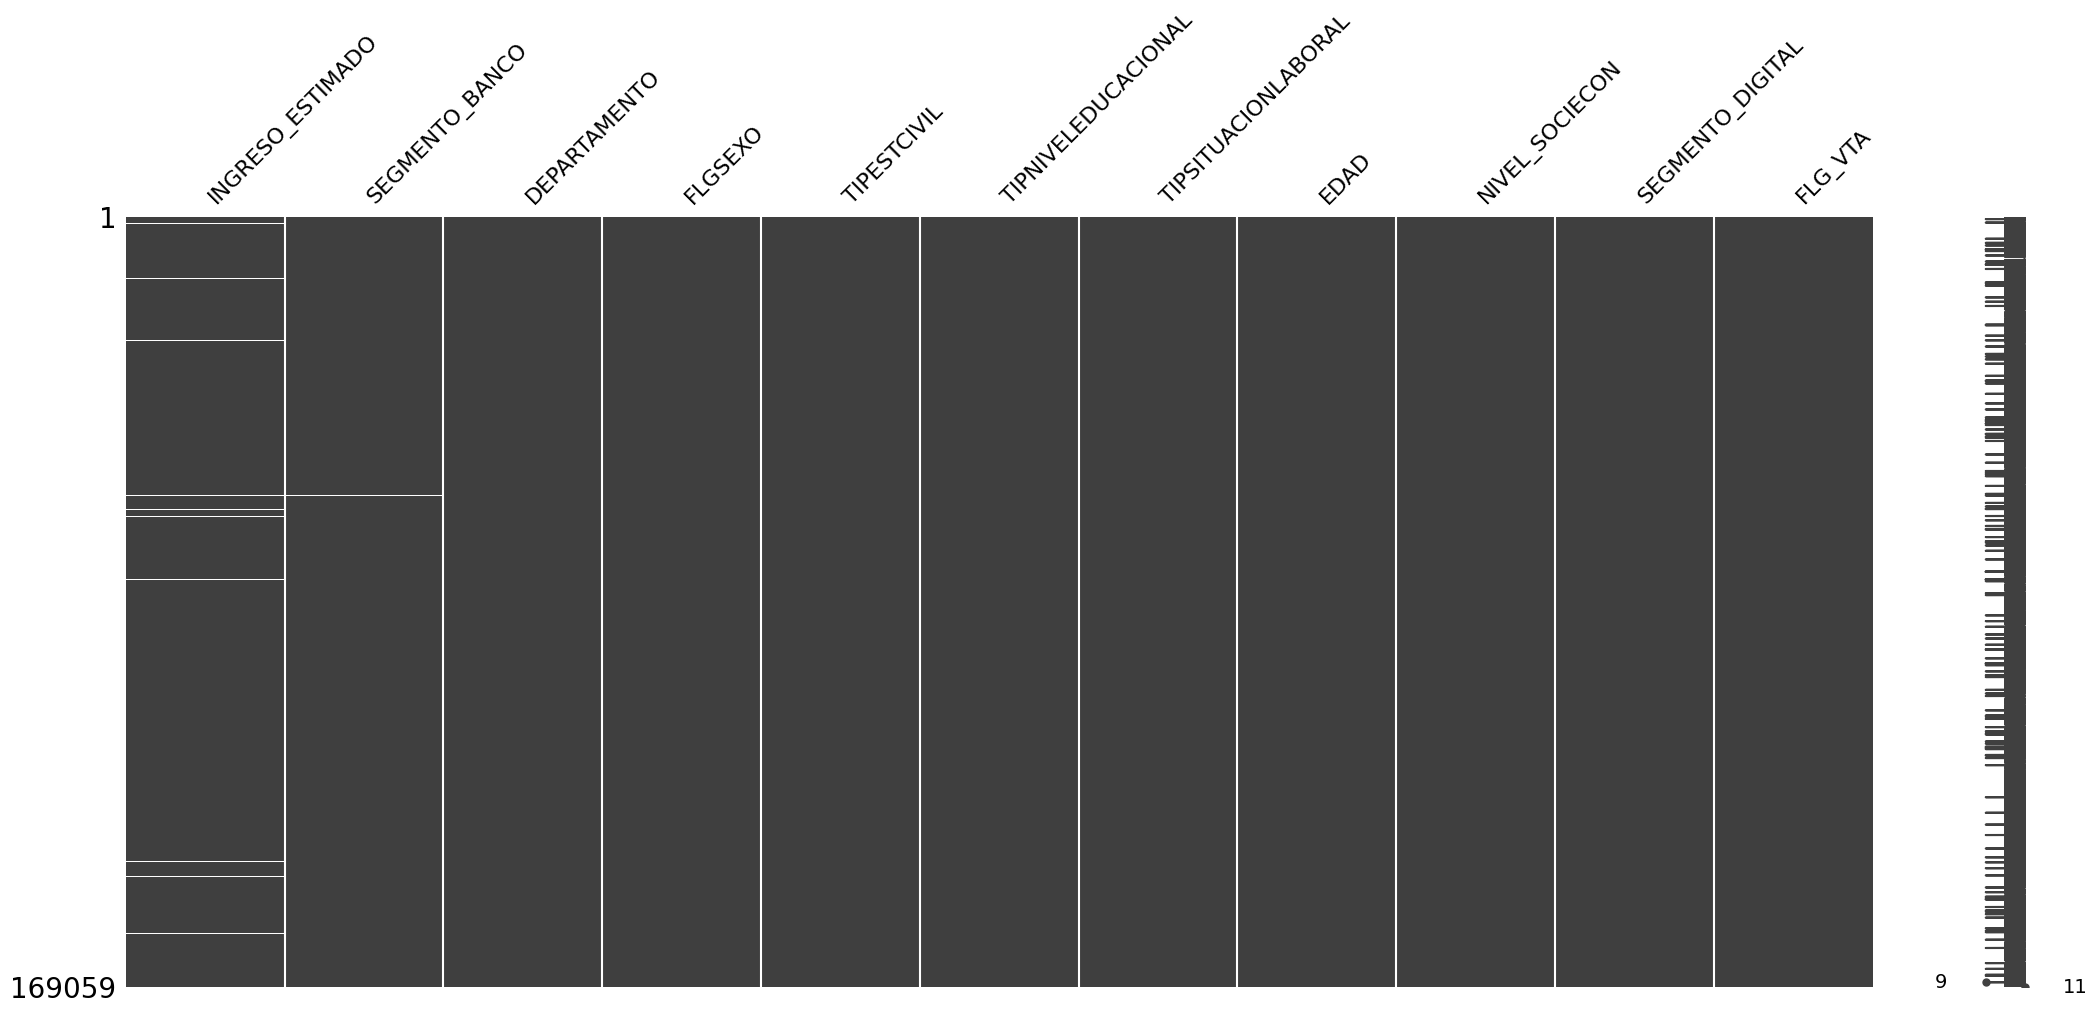

In [7]:
#se visualiza la frecuencia de data nula por filas/observaciones
data.missing.sort_variables_by_missingness()\
.pipe(
    missingno.matrix
)

In [8]:
#cantidad de valores Nulos por cada variable
data.missing.missing_variable_summary().sort_values(by="pct_missing", ascending=False)

,variable,n_missing,n_cases,pct_missing
6,INGRESO_ESTIMADO,1920,169059,1.135698
9,SEGMENTO_BANCO,147,169059,0.086952
5,DEPARTAMENTO,93,169059,0.055010
0,FLGSEXO,1,169059,0.000592
1,TIPESTCIVIL,0,169059,0.000000
2,TIPNIVELEDUCACIONAL,0,169059,0.000000
3,TIPSITUACIONLABORAL,0,169059,0.000000
4,EDAD,0,169059,0.000000
7,NIVEL_SOCIECON,0,169059,0.000000
8,SEGMENTO_DIGITAL,0,169059,0.000000


In [9]:
#En este caso, se podría imputar o eliminar la data. Sin embargo, al eliminar data se podría incursionar en sesgos, asi que lo más recomendado sería realizar imputaciones
# ya que son pocas datas perdidas comparado al total de casos y son categoricas, entonces realizaré la imputación basada en KNN

categorical_columns = data.select_dtypes(include=[object, "category"]).columns
categorical_columns

Index(['FLGSEXO', 'TIPESTCIVIL', 'TIPNIVELEDUCACIONAL', 'TIPSITUACIONLABORAL',
       'DEPARTAMENTO', 'NIVEL_SOCIECON', 'SEGMENTO_DIGITAL', 'SEGMENTO_BANCO'],
      dtype='object')

In [10]:
#Creamos el transformador para OrdinalEncoder
categorical_transformer=sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)
categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['FLGSEXO', 'TIPESTCIVIL', 'TIPNIVELEDUCACIONAL', 'TIPSITUACIONLABORAL',
       'DEPARTAMENTO', 'NIVEL_SOCIECON', 'SEGMENTO_DIGITAL', 'SEGMENTO_BANCO'],
      dtype='object'))])

In [11]:
data_transform_df = pd.DataFrame(
    categorical_transformer.fit_transform(data),
    columns=categorical_transformer.get_feature_names_out(),
    index=data.index
).rename_columns(
    function=lambda x: x.removeprefix("ordinalencoder__")
).rename_columns(
    function=lambda x: x.removeprefix("remainder__")
)

data_transform_df

,FLGSEXO,TIPESTCIVIL,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,DEPARTAMENTO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,EDAD,INGRESO_ESTIMADO,FLG_VTA
0,1.0,4.0,6.0,0.0,18.0,3.0,0.0,6.0,33.0,8087.060000,0.0
1,1.0,0.0,5.0,0.0,15.0,1.0,0.0,7.0,44.0,19000.000000,0.0
2,1.0,0.0,12.0,2.0,15.0,1.0,0.0,2.0,67.0,6684.587500,0.0
3,0.0,0.0,6.0,0.0,15.0,0.0,0.0,9.0,58.0,37019.075000,0.0
4,0.0,0.0,10.0,5.0,15.0,3.0,0.0,1.0,58.0,3070.290000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
169054,1.0,4.0,6.0,1.0,15.0,3.0,0.0,4.0,25.0,1439.513471,0.0
169055,0.0,4.0,12.0,0.0,15.0,3.0,0.0,5.0,31.0,3961.002500,0.0
169056,0.0,0.0,6.0,6.0,15.0,0.0,0.0,1.0,42.0,1179.775000,0.0
169057,0.0,4.0,1.0,0.0,15.0,3.0,0.0,1.0,35.0,2844.545000,0.0


In [12]:
#Realizaremos la imputación por KNN luego de haber realizado el OrdinaleEncoder
knn_imputer = sklearn.impute.KNNImputer()

data_transform_df_knn = data_transform_df.copy(deep=True)

data_transform_df_knn.iloc[:,:]=knn_imputer.fit_transform(data_transform_df).round()
data_transform_df_knn

,FLGSEXO,TIPESTCIVIL,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,DEPARTAMENTO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,EDAD,INGRESO_ESTIMADO,FLG_VTA
0,1.0,4.0,6.0,0.0,18.0,3.0,0.0,6.0,33.0,8087.0,0.0
1,1.0,0.0,5.0,0.0,15.0,1.0,0.0,7.0,44.0,19000.0,0.0
2,1.0,0.0,12.0,2.0,15.0,1.0,0.0,2.0,67.0,6685.0,0.0
3,0.0,0.0,6.0,0.0,15.0,0.0,0.0,9.0,58.0,37019.0,0.0
4,0.0,0.0,10.0,5.0,15.0,3.0,0.0,1.0,58.0,3070.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
169054,1.0,4.0,6.0,1.0,15.0,3.0,0.0,4.0,25.0,1440.0,0.0
169055,0.0,4.0,12.0,0.0,15.0,3.0,0.0,5.0,31.0,3961.0,0.0
169056,0.0,0.0,6.0,6.0,15.0,0.0,0.0,1.0,42.0,1180.0,0.0
169057,0.0,4.0,1.0,0.0,15.0,3.0,0.0,1.0,35.0,2845.0,0.0


<AxesSubplot:xlabel='SEGMENTO_BANCO', ylabel='DEPARTAMENTO'>

c:\Users\EDSON\Desktop\DATAWRANGLING\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


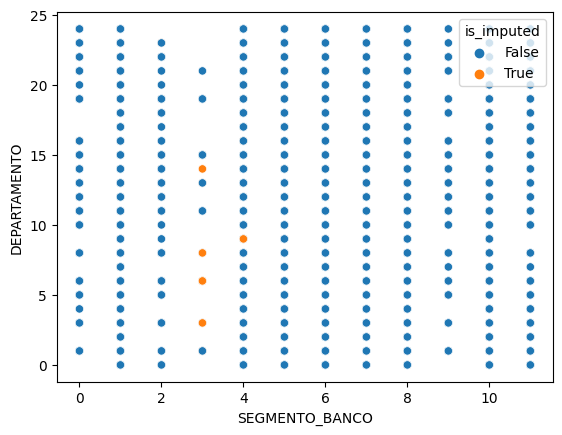

In [18]:
# Visualizamos el comportamiento de la data imputada para las variables

pd.concat([
    data_transform_df_knn,
    data_transform_df.missing.create_shadow_matrix(True, False, suffix='_imp', only_missing=True)
        ], axis=1
).missing.scatter_imputation_plot(
    x = "SEGMENTO_BANCO",
    y = "DEPARTAMENTO"
)

In [45]:
df = data_transform_df_knn.copy(deep=True)
df.head()

,FLGSEXO,TIPESTCIVIL,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,DEPARTAMENTO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,EDAD,INGRESO_ESTIMADO,FLG_VTA
0,1.0,4.0,6.0,0.0,18.0,3.0,0.0,6.0,33.0,8087.0,0.0
1,1.0,0.0,5.0,0.0,15.0,1.0,0.0,7.0,44.0,19000.0,0.0
2,1.0,0.0,12.0,2.0,15.0,1.0,0.0,2.0,67.0,6685.0,0.0
3,0.0,0.0,6.0,0.0,15.0,0.0,0.0,9.0,58.0,37019.0,0.0
4,0.0,0.0,10.0,5.0,15.0,3.0,0.0,1.0,58.0,3070.0,0.0


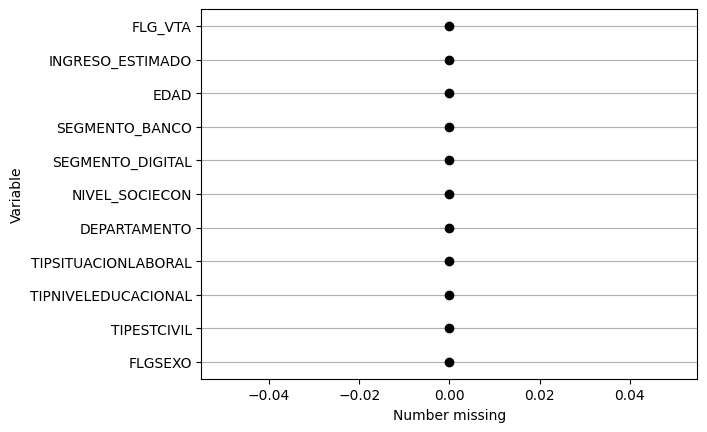

In [46]:
df.missing.missing_variable_plot()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169059 entries, 0 to 169058
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   FLGSEXO              169059 non-null  float64
 1   TIPESTCIVIL          169059 non-null  float64
 2   TIPNIVELEDUCACIONAL  169059 non-null  float64
 3   TIPSITUACIONLABORAL  169059 non-null  float64
 4   DEPARTAMENTO         169059 non-null  float64
 5   NIVEL_SOCIECON       169059 non-null  float64
 6   SEGMENTO_DIGITAL     169059 non-null  float64
 7   SEGMENTO_BANCO       169059 non-null  float64
 8   EDAD                 169059 non-null  float64
 9   INGRESO_ESTIMADO     169059 non-null  float64
 10  FLG_VTA              169059 non-null  float64
dtypes: float64(11)
memory usage: 14.2 MB


In [48]:
#estandarizamos la data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled['FLG_VTA']=df_scaled['FLG_VTA'].astype(int)
df_scaled.head(1)

,FLGSEXO,TIPESTCIVIL,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,DEPARTAMENTO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,EDAD,INGRESO_ESTIMADO,FLG_VTA
0,1.0,0.8,0.5,0.0,0.75,1.0,0.0,0.545455,0.282051,0.015423,0


In [49]:
df_scaled.describe()

,FLGSEXO,TIPESTCIVIL,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,DEPARTAMENTO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,EDAD,INGRESO_ESTIMADO,FLG_VTA
count,169059.000000,169059.000000,169059.000000,169059.000000,169059.000000,169059.000000,169059.000000,169059.000000,169059.000000,169059.000000,169059.000000
mean,0.632300,0.516331,0.564046,0.151557,0.571428,0.725902,0.092506,0.458426,0.330646,0.011181,0.002254
std,0.482181,0.373167,0.367058,0.309661,0.158076,0.349949,0.242892,0.237659,0.084868,0.015750,0.047419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.083333,0.000000,0.625000,0.333333,0.000000,0.363636,0.264957,0.003516,0.000000
50%,1.000000,0.800000,0.750000,0.000000,0.625000,1.000000,0.000000,0.454545,0.316239,0.006748,0.000000
75%,1.000000,0.800000,0.833333,0.000000,0.625000,1.000000,0.000000,0.636364,0.376068,0.012967,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


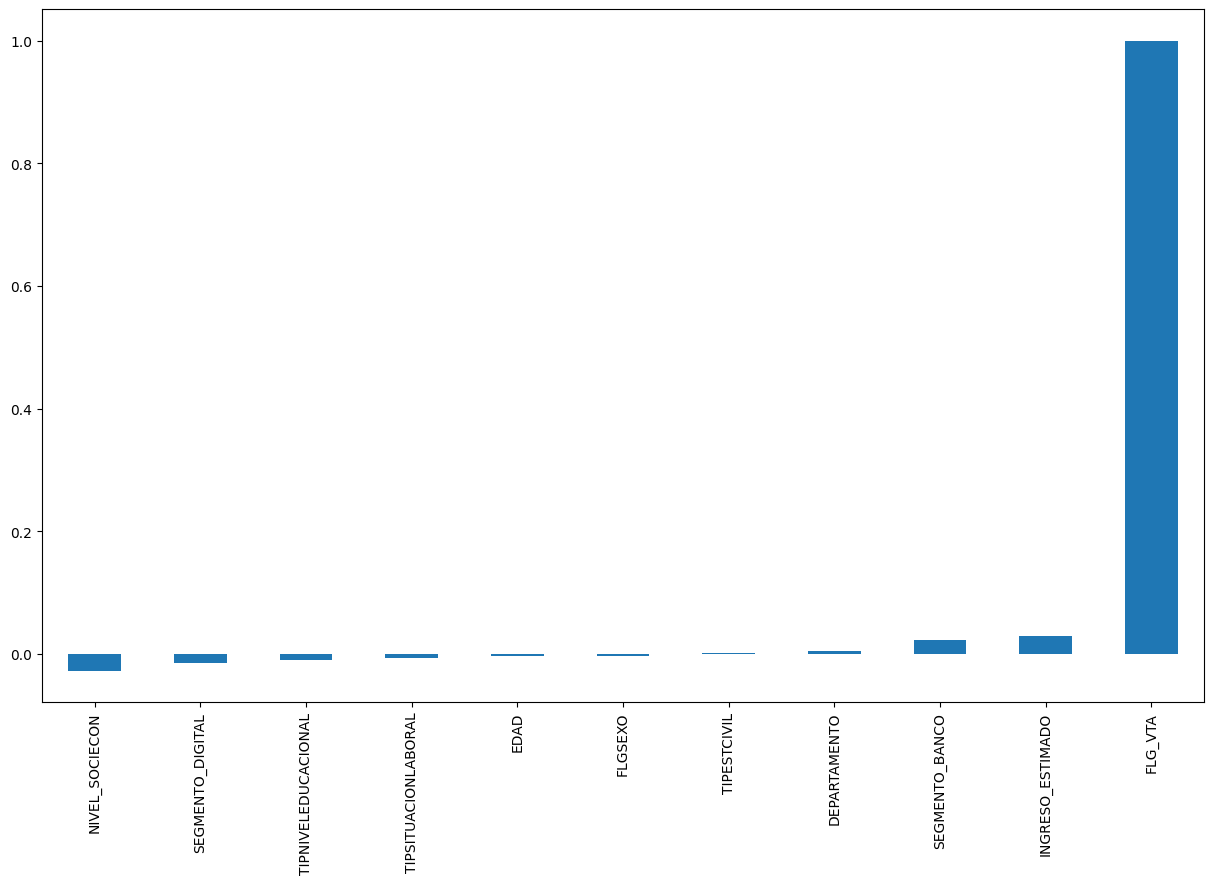

In [50]:
#verificamos la correlación
#Se puede visualizar que se tiene baja correlación TIPESTCIVIL CON FLG_VTA
#Se procede a eliminarlo
plt.figure(figsize=(15,9))
df_scaled.corr()['FLG_VTA'].sort_values(ascending=True).plot(kind='bar')
plt.show()

In [51]:
#Se elimina el TIPESTCIVIL por tener bajísima correlación con el FLG_VA
df_scaled.drop(columns=['TIPESTCIVIL', 'FLGSEXO', 'EDAD'], inplace=True, axis=1)
df_scaled.head(1)

,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,DEPARTAMENTO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,INGRESO_ESTIMADO,FLG_VTA
0,0.5,0.0,0.75,1.0,0.0,0.545455,0.015423,0


# MODELAMIENTO DE LA DATA

In [52]:
X = df_scaled.drop(['FLG_VTA'], axis=1)
y = df_scaled['FLG_VTA']

In [53]:
# Se encuentra que hay una gran cantidad de data desbalanceada abismalmente.
# En este caso, usaremos SMOOTEEN para balancear la data
df_scaled.FLG_VTA.value_counts()

0    168678
1       381
Name: FLG_VTA, dtype: int64

In [54]:
# Tratamos de corregir el desbalance
from imblearn.combine import SMOTEENN

imp = SMOTEENN(sampling_strategy=0.99)
X_bal, y_bal = imp.fit_resample(X, y)

y_bal.value_counts()

0    139655
1    126912
Name: FLG_VTA, dtype: int64

In [55]:
# Separamos la data en entrenamiento y testeo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

model = LogisticRegression(solver='lbfgs', C=1.65, n_jobs=-1, penalty='l2')
model.fit(X_train, y_train)

y_test_hat = model.predict(X_test)

print(
    "Accuracy => {}".format(round(accuracy_score(y_test, y_test_hat), 2)),
    "AUC => {}".format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),2)),
    sep='\n'
      )

Accuracy => 0.69
AUC => 0.75


In [56]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     27768
           1       0.68      0.68      0.68     25546

    accuracy                           0.69     53314
   macro avg       0.69      0.69      0.69     53314
weighted avg       0.69      0.69      0.69     53314



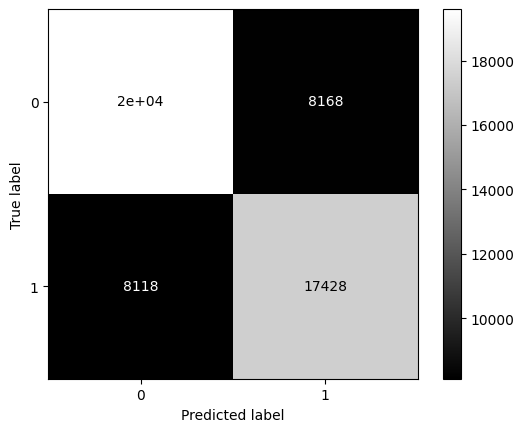

In [57]:
cm = confusion_matrix(y_test, y_test_hat, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap = "gray")
plt.show()

AxesSubplot(0.125,0.11;0.775x0.77)


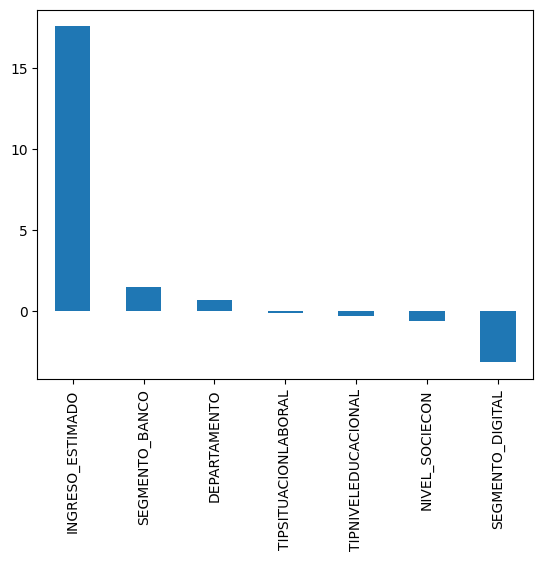

In [58]:
weights=pd.Series(model.coef_[0], index=X.columns)
print(weights.sort_values(ascending=False)[:10].plot(kind='bar'))

In [68]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, r2_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [74]:
#Definimos nuestra funcion para plotear el confusion matriz
def print_confusion_matrix(confusion_matrix, accuracy):
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap = 'gist_earth')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix - XGBOOST') #Cambiamos solo el nombre para los graficos con Seaborn y Matlplotlib
    ###plt.title('Confusion matrix. Acc={}'.format(accuracy))
    plt.show()  

In [70]:
def metricas(model):
    prediccion          = model.predict(X_test) #Generamos predicciones
    
    Confusion_Test      = confusion_matrix(y_test,# Valores verdaderos
                                  prediccion) # Valores predecidos
    
    verdadero_negativo, falso_positivo, falso_negativo, verdadero_positivo = Confusion_Test.ravel() #Separamos para usar metricas
    
    #Obtenemos algunas metricas facilmente
    accuracy       = accuracy_score(y_test, prediccion)
    print("Se obtuvo un -> Accuracy score: %.2f%%" % (accuracy * 100.0))

    recall         = recall_score(y_test, prediccion)
    print("Se obtuvo un -> Recall score: %.2f%%" % (recall * 100.0))

    precision      = precision_score(y_test, prediccion)
    print("Se obtuvo un -> Precision score: %.2f%%" % (precision * 100.0))
    
    #Obtendremos algunas metricas manualmente
    specificity    = verdadero_negativo / (verdadero_negativo+falso_positivo)
    specificity    = specificity * 100.0
    print(f"Se obtuvo un -> Specificity score: {round((specificity),2)}%")
    
    F1_SCORE        = f1_score(y_test, prediccion)
    F1_SCORE        = F1_SCORE * 100.0
    print(f'Se obtuvo un -> F1 score: {round((F1_SCORE),2)}%')
    
    Data_conform= pd.DataFrame(Confusion_Test, index =  ['Actual Failure', 'Actual Success'],
                    columns = ['Predicted Failure', 'Predicted Success'])
    return(Data_conform)

In [71]:
## MODELADO PARA XGBOOST
model_Xgb = XGBClassifier()
model_Xgb.fit(X_train, y_train)

print(f'XGBoost Train score: {model_Xgb.score(X_train, y_train)}')
print(f'XGBoost Test score: {model_Xgb.score(X_test, y_test)}')

XGBoost Train score: 0.9794281909281464
XGBoost Test score: 0.9794050343249427


In [72]:
metricas(model_Xgb)

Se obtuvo un -> Accuracy score: 97.94%
Se obtuvo un -> Recall score: 99.19%
Se obtuvo un -> Precision score: 96.61%
Se obtuvo un -> Specificity score: 96.79%
Se obtuvo un -> F1 score: 97.88%


,Predicted Failure,Predicted Success
Actual Failure,26878,890
Actual Success,208,25338


In [76]:
y_test_hat = model_Xgb.predict(X_test) 
print(
    "Accuracy => {}".format(round(accuracy_score(y_test, y_test_hat), 2)),
    "AUC => {}".format(round(roc_auc_score(y_test, model_Xgb.predict_proba(X_test)[:,1]),2)),
    sep='\n'
      )

Accuracy => 0.98
AUC => 1.0


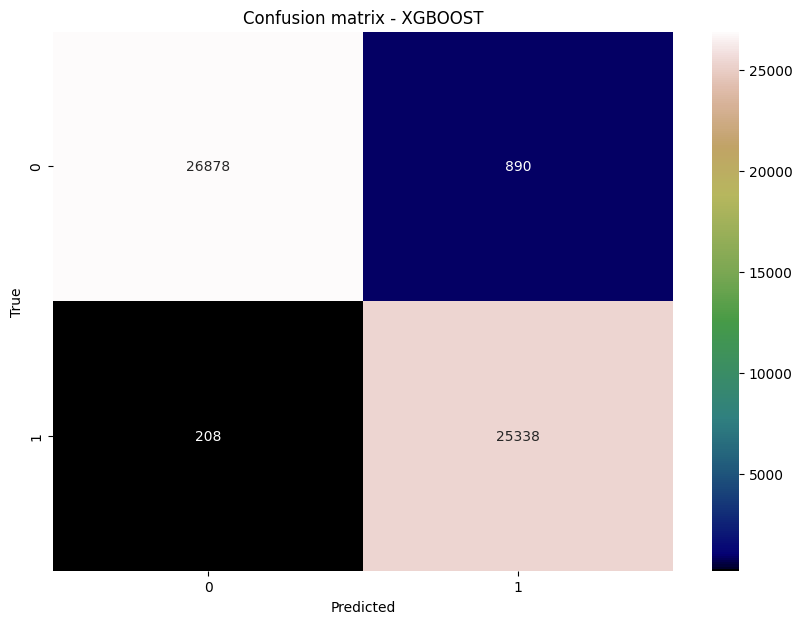

In [75]:
y_pred_test = model_Xgb.predict(X_test)
print_confusion_matrix(confusion_matrix(y_test,y_pred_test), accuracy_score(y_test, y_pred_test))